In [27]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cftime
import dask
import xarrayutils
import cartopy.crs as ccrs
from xmip.preprocessing import combined_preprocessing
from xmip.preprocessing import replace_x_y_nominal_lat_lon
from xmip.drift_removal import replace_time
from xmip.postprocessing import concat_experiments
import xmip.drift_removal as xm_dr
import xmip as xm
import xesmf as xe
import datetime
from dateutil.relativedelta import relativedelta
import utils
import cf_xarray as cfxr

from sklearn.linear_model import LinearRegression
import scipy.signal as signal
from scipy import stats
from datetime import timedelta

import seaborn as sns
import matplotlib as mpl
import cmocean
import cmocean.cm as cmo
from matplotlib.gridspec import GridSpec

from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

import string
alphabet = list(string.ascii_lowercase)       

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
dask.config.set(**{'array.slicing.split_large_chunks': True})

# Import data

In [6]:
#define our weights for models (grouping UKESM and CANESM realizations)
model_weights = utils.model_weights

onepct_model_weights = utils.onepct_model_weights

G_model_weights = utils.G_model_weights

pictrl_model_weights = utils.pictrl_model_weights

fourx_model_weights = utils.fourx_model_weights

## Green's Function

In [7]:
G_ds_path = 'Outputs/G_pulse_ds.nc4'
G_cdr_ds_path = 'Outputs/G_cdr_ds.nc4'

G_ds = utils.import_polyfit_G(G_ds_path, G_cdr_ds_path)

## Convolution

In [8]:
conv_hist_ds = xr.open_dataset('Outputs/hist_co2_only_conv_ds.nc4')['__xarray_dataarray_variable__']
conv_4x_ds = xr.open_dataset('Outputs/4x_conv_ds.nc4')['__xarray_dataarray_variable__']

conv_4x_ds = conv_4x_ds.expand_dims(dim ={'experiment':['4x']}).weighted(fourx_model_weights).mean(dim = 'model').mean(dim = 'pulse_type')
conv_hist_ds = conv_hist_ds.expand_dims(dim ={'experiment':['hist']}).mean(dim = 'model').mean(dim = 'pulse_type')

In [9]:
conv_ds = xr.open_dataset('Outputs/conv_ds.nc4')['__xarray_dataarray_variable__']

conv_1000gtc = conv_ds.sel(experiment = '1000gtc').where(conv_ds.model.isin(list(utils.model_run_1pct_1000gtc_dict.keys())), drop = True).weighted(utils.onepct_1000gtc_weights).mean(dim = 'model').mean(dim = 'pulse_type')
conv_1pct = conv_ds.sel(experiment = '1pct').where(conv_ds.model.isin(list(utils.model_run_1pct_dict.keys())), drop = True).weighted(utils.onepct_model_weights).mean(dim = 'model').mean(dim = 'pulse_type')

In [10]:
conv_ds = xr.concat([conv_1000gtc, conv_1pct, conv_4x_ds, conv_hist_ds], dim = 'experiment')

## CMIP6 data

In [11]:
ds_hist_dif = xr.open_dataset('Outputs/hist_co2_only_ds_dif.nc4')
ds_4x_dif = xr.open_dataset('Outputs/4x_ds_dif.nc4')


ds_4x_dif = ds_4x_dif.expand_dims(dim ={'experiment':['4x']}).weighted(utils.fourx_model_weights).mean(dim = 'model')
ds_hist_dif = ds_hist_dif.expand_dims(dim ={'experiment':['hist']}).mean(dim = 'model')

In [12]:
ds_dif = xr.open_dataset('Outputs/ds_dif.nc4')

ds_1000gtc = ds_dif.sel(experiment = '1000gtc').where(ds_dif.model.isin(list(utils.model_run_1pct_1000gtc_dict.keys())), drop = True).weighted(utils.onepct_1000gtc_weights).mean(dim = 'model')
ds_1pct = ds_dif.sel(experiment = '1pct').where(ds_dif.model.isin(list(utils.model_run_1pct_dict.keys())), drop = True).weighted(utils.onepct_model_weights).mean(dim = 'model')

In [13]:

dif_ds = xr.concat([ds_1000gtc, ds_1pct, ds_4x_dif, ds_hist_dif], dim = 'experiment')

## Emissions profile

In [14]:
emis_profile = xr.open_dataset('Outputs/emis_profile.nc4')
emis_profile_4x = xr.open_dataset('Outputs/4x_emis_profile.nc4')
emis_profile_hist = xr.open_dataset('Outputs/hist_co2_only_emis_profile.nc4')


In [15]:
emis_profile_4x = emis_profile_4x['emis'].expand_dims(dim ={'experiment':['4x']}).weighted(utils.fourx_model_weights).mean(dim = 'model')
emis_profile_hist = emis_profile_hist['emis'].expand_dims(dim ={'experiment':['hist']}).mean(dim = 'model')
emis_profile_1000gtc = emis_profile['emis'].where(ds_dif.model.isin(list(utils.model_run_1pct_1000gtc_dict.keys())), drop = True).sel(experiment = '1000gtc').weighted(utils.onepct_1000gtc_weights).mean(dim = 'model')
emis_profile_1pct = emis_profile['emis'].where(ds_dif.model.isin(list(utils.model_run_1pct_dict.keys())), drop = True).sel(experiment = '1pct').weighted(utils.onepct_model_weights).mean(dim = 'model')

In [16]:
emis_profile = xr.concat([emis_profile_1pct, emis_profile_1000gtc, emis_profile_hist, emis_profile_4x], dim = 'experiment')

In [17]:
emis_profile = emis_profile.rename({'year':'s'})

## PiCtrl

In [18]:
ds_pictrl = xr.open_dataset('Outputs/ds_pictrl.nc4')

## RTCRE

In [19]:
RTCRE = xr.open_dataset('Outputs/RTCRE.nc')['__xarray_dataarray_variable__']

# Settings and Define our Model Weights

In [20]:
type_color = utils.type_color
model_color = utils.model_color

In [21]:
A = utils.A
ds_out = utils.ds_out

In [22]:
proper_names = utils.proper_names

## Sum and Multiply Emissions by RTCRE

In [23]:
RTCRE_conv = RTCRE*emis_profile.cumsum('s')

## Different RTCRE

In [24]:
## year 20 for 100GtC total emitted on average

## Plot

In [25]:
import cmocean

/tmp/ipykernel_507/4067693677.py:14: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.25)
/net/fs11/d0/emfreese/CO2_GF/utils.py:397: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=newcmap)
/net/fs11/d0/emfreese/CO2_GF/utils.py:397: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=newcmap)
/net/fs11/d0/emfreese/CO2_GF/utils.py:397: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=newcmap)
/tmp/ipykernel_507/4067693677.py:14: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.25)
/net/fs11/d0/emfreese/CO2_GF/utils.py:397: UserWarning: Trying to register the cmap 'shift

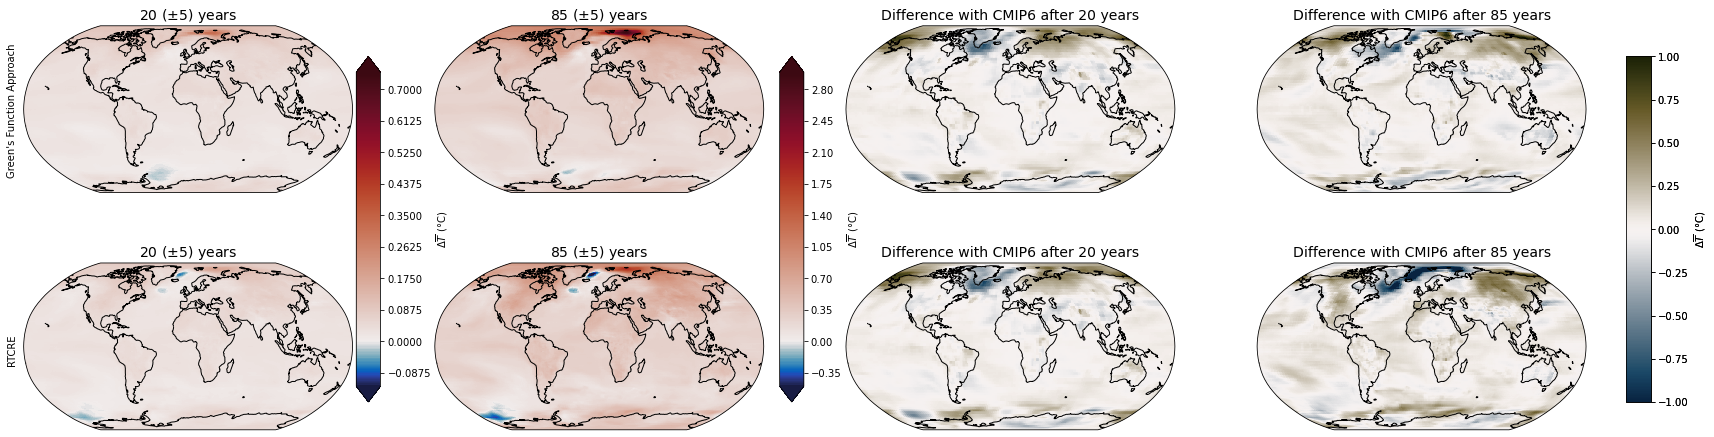

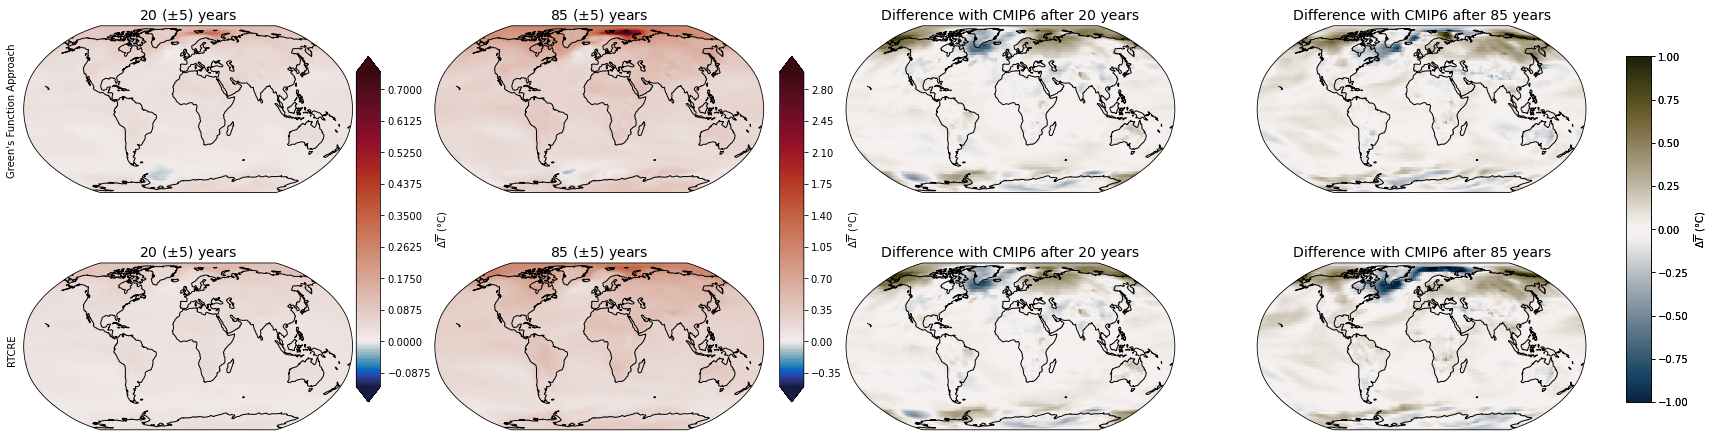

In [32]:

#levels = {20:np.arange(-0.5,1.5,0.01) , 85:np.arange(-1.6,7,0.1)}

levels = {'1pct':np.arange(-0.5,7,0.01) , '1000gtc':np.arange(-0.5,7,0.01) , '4x':np.arange(-8,40,0.1) , 'hist':np.arange(-0.5,3,0.01) }

vmin = -2
vmax = 2
yr_dif = 5
TCRE_yr = 20
for exp in ['hist']:#conv_ds.experiment.values:
    for TCRE_yr in [20, 70]:
        cmap = cmocean.cm.balance
        fig, ((ax1, ax2, ax3, ax7),(ax4, ax5, ax6, ax8))= plt.subplots(2,4, figsize = [28,8], subplot_kw = {'projection':ccrs.Robinson()}, constrained_layout = True)

        plt.subplots_adjust(wspace=0.25)

        ##########1pct exp##################
        ##contours of convolution-1pct difference
        for t, ax in zip([20,85],[ax1,ax2]):
            if t == 20 and exp == '4x':
                lev = levels[exp]
            elif t == 20:
                lev = levels[exp]/4
            elif t == 85:
                lev = levels[exp]
            if ax == ax1:
                add_cbar = False
            elif ax == ax2:
                add_cbar = True

            cmap_shifted = utils.shiftedColorMap(cmap, start=0, midpoint= 1 - lev.max() / (lev.max() + abs(lev.min())), stop=1, name='shiftedcmap')
            axp1 = (conv_ds).sel(s = slice(t-yr_dif, t+yr_dif)).mean(dim = 's').sel(experiment = exp).plot(ax = ax, 
                                                                                                              cmap = cmap_shifted, levels = lev, extend = 'both', 
                                                                                                              add_colorbar = False,     
                                                                                                              transform = ccrs.PlateCarree())
            ax.coastlines()
            ax.set_title(f'{t} ($\pm 5$) years', fontsize = 14)


            if t == 20:
                cbaxes = fig.add_axes([.29,.2,.012,.6])
                cb = plt.colorbar(axp1, cax = cbaxes)
                cb.set_label('$\Delta \overline{T}$ ($\degree$C)')



        ax1.set_title('20 ($\pm 5$) years', fontsize = 14)
        ax2.set_title('85 ($\pm 5$) years', fontsize = 14)

        plt.text(x = -0.05, y = 0.1, s = 'Green\'s Function Approach', rotation = 90, transform = ax1.transAxes)
        plt.text(x = -0.05, y = 0.4, s = 'RTCRE', rotation = 90, transform = ax4.transAxes)
        
        ##########RTCRE exp##################
        ##contours of convolution-1pct difference
        for t, ax in zip([20,85],[ax4,ax5]):
            if t == 20 and exp == '4x':
                lev = levels[exp]
            elif t == 20:
                lev = levels[exp]/4
            elif t == 85:
                lev = levels[exp]
                
            if ax == ax3:
                add_cbar = False
            elif ax == ax4:
                add_cbar = True
            axp2 = (RTCRE_conv.sel(year = TCRE_yr)).sel(s = slice(t-yr_dif, t+yr_dif)).mean(dim = 's').sel(experiment = exp).plot(ax = ax, 
                                                                                                              cmap = cmap_shifted, levels = lev, extend = 'both', 
                                                                                                              add_colorbar = False,     
                                                                                                              transform = ccrs.PlateCarree())
            ax.coastlines()
            ax.set_title(f'{t} ($\pm 5$) years', fontsize = 14)


            if t == 85:
                cbaxes = fig.add_axes([.5,.2,.012,.6])
                cb = plt.colorbar(axp2, cax = cbaxes)
                cb.set_label('$\Delta \overline{T}$ ($\degree$C)')


        if exp == '4x':
            cmap = cmocean.cm.diff
            vmin = -10
            vmax = 10
            cmap_shifted = utils.shiftedColorMap(cmap, start=0, midpoint= 1 - vmax / (vmax + abs(vmin)), stop=1, name='shiftedcmap')
            
        else:
            cmap = cmocean.cm.diff
            vmin = -1
            vmax = 1
            cmap_shifted = utils.shiftedColorMap(cmap, start=0, midpoint= 1 - vmax / (vmax + abs(vmin)), stop=1, name='shiftedcmap')
            
        ##########Dif convolution and CMIP6 exp##################
        ##contours of convolution-1pct difference
        for t, ax in zip([20, 85],[ax3,ax7]):

            ((conv_ds - dif_ds['tas']).sel(s = slice(t-yr_dif, t+yr_dif)).mean(dim = 's').sel(experiment = exp)).plot(ax = ax, 
                                                                                                                          cmap = cmap_shifted, extend = 'both', 
                                                                                                                          add_colorbar = False,  vmin = vmin, vmax = vmax,   
                                                                                                                          transform = ccrs.PlateCarree())
            ax.set_title(f'Difference with CMIP6 after {t} years', fontsize = 14)
            ax.coastlines()
        ##########Dif RTCRE and CMIP6 exp##################
        ##contours of convolution-1pct difference
        for t, ax in zip([20, 85],[ax6, ax8]):

            axp6 = ((RTCRE_conv.sel(year = TCRE_yr) - dif_ds['tas']).sel(s = slice(t-yr_dif, t+yr_dif)).mean(dim = 's').sel(experiment = exp)).plot(ax = ax, transform = ccrs.PlateCarree(),
                                                                                                                          cmap = cmap_shifted,  extend = 'both', vmin = vmin, vmax = vmax,
                                                                                                                          add_colorbar = False,     
                                                                                                                          )

            ax.coastlines()
            ax.set_title(f'Difference with CMIP6 after {t} years', fontsize = 14)


            cbaxes = fig.add_axes([0.92,.2,.012,.6])
            cb = plt.colorbar(axp6, cax = cbaxes)
            cb.set_label('$\Delta \overline{T}$ ($\degree$C)')


        plt.savefig(f'figures/paper/supplement/temp_dif_{TCRE_yr}RTCRE_GF_{exp}.png', bbox_inches = 'tight', dpi = 200)
        plt.savefig(f'figures/paper/supplement/temp_dif_{TCRE_yr}RTCRE_GF_{exp}.pdf', bbox_inches = 'tight', dpi = 200)


/net/fs11/d0/emfreese/CO2_GF/utils.py:397: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=newcmap)
/net/fs11/d0/emfreese/CO2_GF/utils.py:397: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=newcmap)
/net/fs11/d0/emfreese/CO2_GF/utils.py:397: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=newcmap)
/net/fs11/d0/emfreese/CO2_GF/utils.py:397: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=newcmap)
/net/fs11/d0/emfreese/CO2_GF/utils.py:397: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=newcmap)
/net/fs11/d0/emfreese/CO2_GF/utils.py:397: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=newcmap)
/net/fs11/d0/emfreese/CO2_GF/utils.py:397: UserWarning: Trying to register t

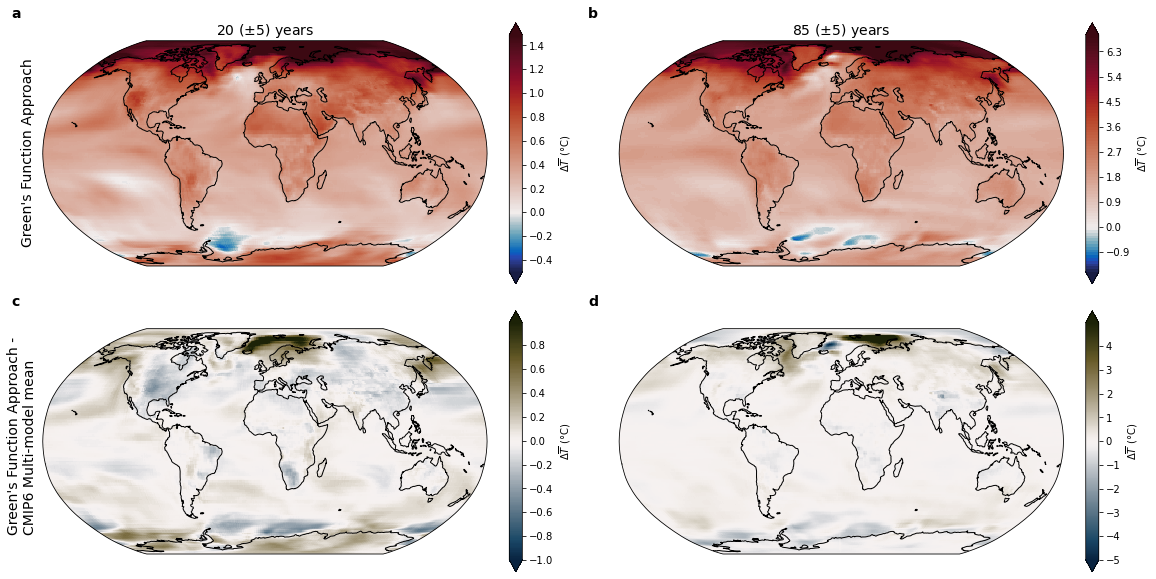

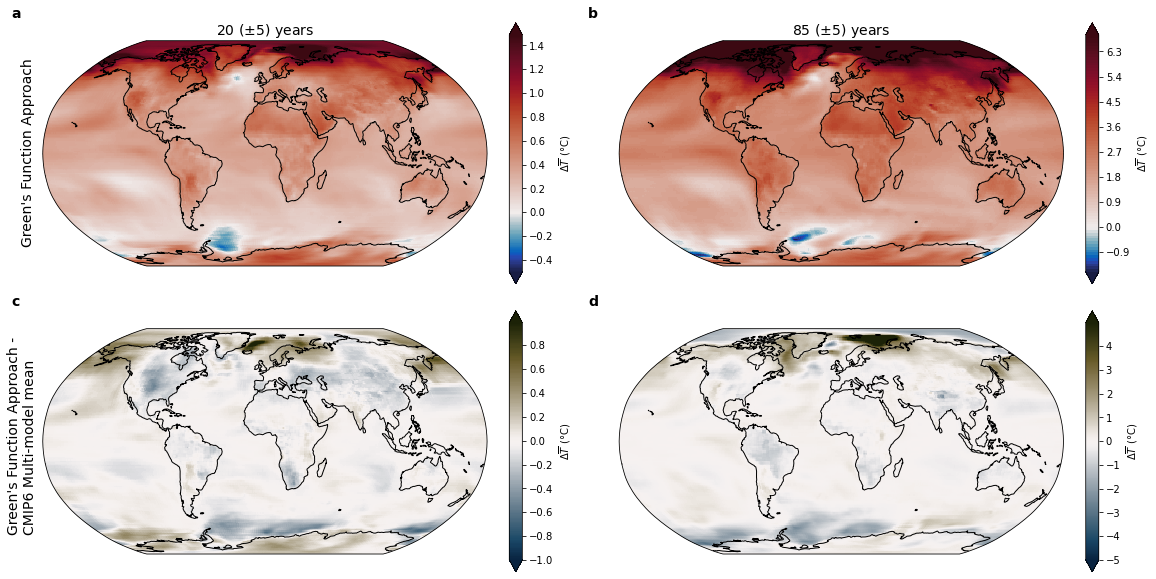

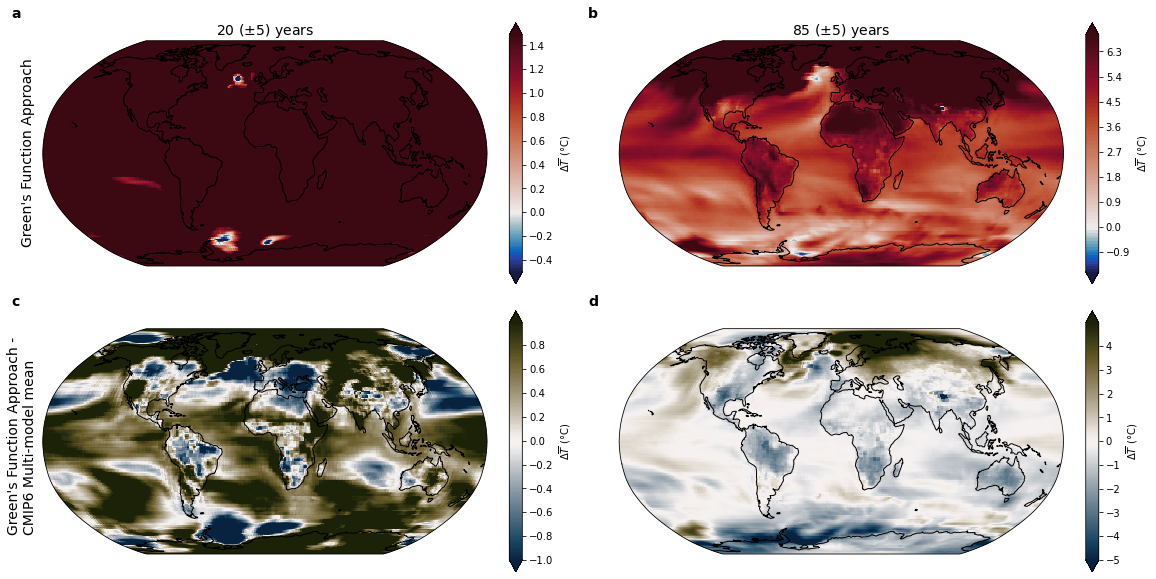

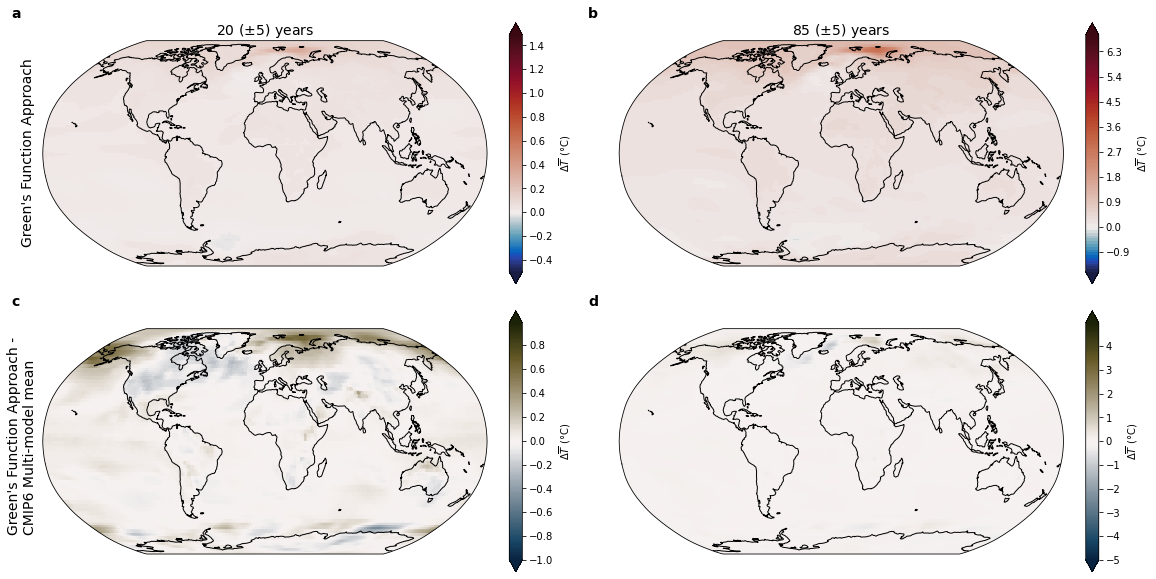

In [115]:
for exp in conv_ds.experiment.values:
    cmap = cmocean.cm.balance
    levels = {20:np.arange(-0.5,1.5,0.01) , 85:np.arange(-1.6,7,0.1)}
    yr_dif = 10
    fig, axes = plt.subplots(2,2,figsize = [16,8], subplot_kw = {'projection':ccrs.Robinson()}, constrained_layout = True)
    #for idx_c, exp in enumerate(conv_ds.experiment.values):
    for idx_t, t in enumerate([20,85]):
        ax = axes[0, idx_t]
        cmap_shifted = utils.shiftedColorMap(cmap, start=0, midpoint= 1 - levels[t].max() / (levels[t].max() + abs(levels[t].min())), stop=1, name='shiftedcmap')

        axp = conv_ds.sel(s = slice(t-yr_dif, t+yr_dif-1)).mean(dim = 's').sel(experiment = exp).plot(ax = ax, 
                                                                                                  cmap = cmap_shifted, levels = levels[t],
                                                                                                  extend = 'both', 
                                                                                                  add_colorbar = True,  cbar_kwargs = {'label':'$\Delta \overline{T}$ ($\degree$C)'},   
                                                                                                  transform = ccrs.PlateCarree())
        ax.coastlines()
        ax.set_title(f'{t} ($\pm 5$) years', fontsize = 14)


    cmap = cmocean.cm.diff
    levels = {20:np.arange(-1,1,0.01) , 85:np.arange(-5,5,0.01)}
    for idx_t, t in enumerate([20,85]):
        ax = axes[1, idx_t]      
        cmap_shifted = utils.shiftedColorMap(cmap, start=0, midpoint= 1 - levels[t].max() / (levels[t].max() + abs(levels[t].min())), stop=1, name='shiftedcmap')
        axp = (conv_ds-dif_ds['tas']).sel(s = slice(t-yr_dif, t+yr_dif-1)).mean(dim = 's').sel(experiment = exp).plot(ax = ax, 
                                                                                                  cmap = cmap_shifted, levels = levels[t],
                                                                                                  extend = 'both', 
                                                                                                  add_colorbar = True, cbar_kwargs = {'label':'$\Delta \overline{T}$ ($\degree$C)'},   
                                                                                                  transform = ccrs.PlateCarree())
        ax.coastlines()
        ax.set_title(' ')
    #plt.subplots_adjust(wspace = 0.1)

    axes[0,0].text(x = -0.05, y = 0.1, s ='Green\'s Function Approach', transform=axes[0,0].transAxes, rotation = 'vertical', fontsize = 14)
    axes[1,0].text(x = -0.08, y = 0.1, s ='Green\'s Function Approach - \nCMIP6 Multi-model mean', transform=axes[1,0].transAxes, rotation = 'vertical', fontsize = 14)

    #subplot labels, a, b, c, d
    alpha_labels = iter(alphabet)
    for ax in axes.reshape(-1):
        label = next(alpha_labels)
        ax.text(x = -0.07, y =1.1, s = label, transform=ax.transAxes, fontweight="bold", fontsize = 14)

    plt.savefig(f'figures/supplement/figure2_GF_dif_{exp}.png', bbox_inches = 'tight', dpi = 200)
    plt.savefig(f'figures/supplement/figure2_GF_dif_{exp}.pdf', bbox_inches = 'tight', dpi = 200)

In [50]:
exp_dict = {'1pct':'1pct CO$_2$ experiment','1000gtc':'1pct-1000PgC branch experiment','4x':'4x CO$_2$ experiment','hist':'hist-CO$_2$ experiment'}

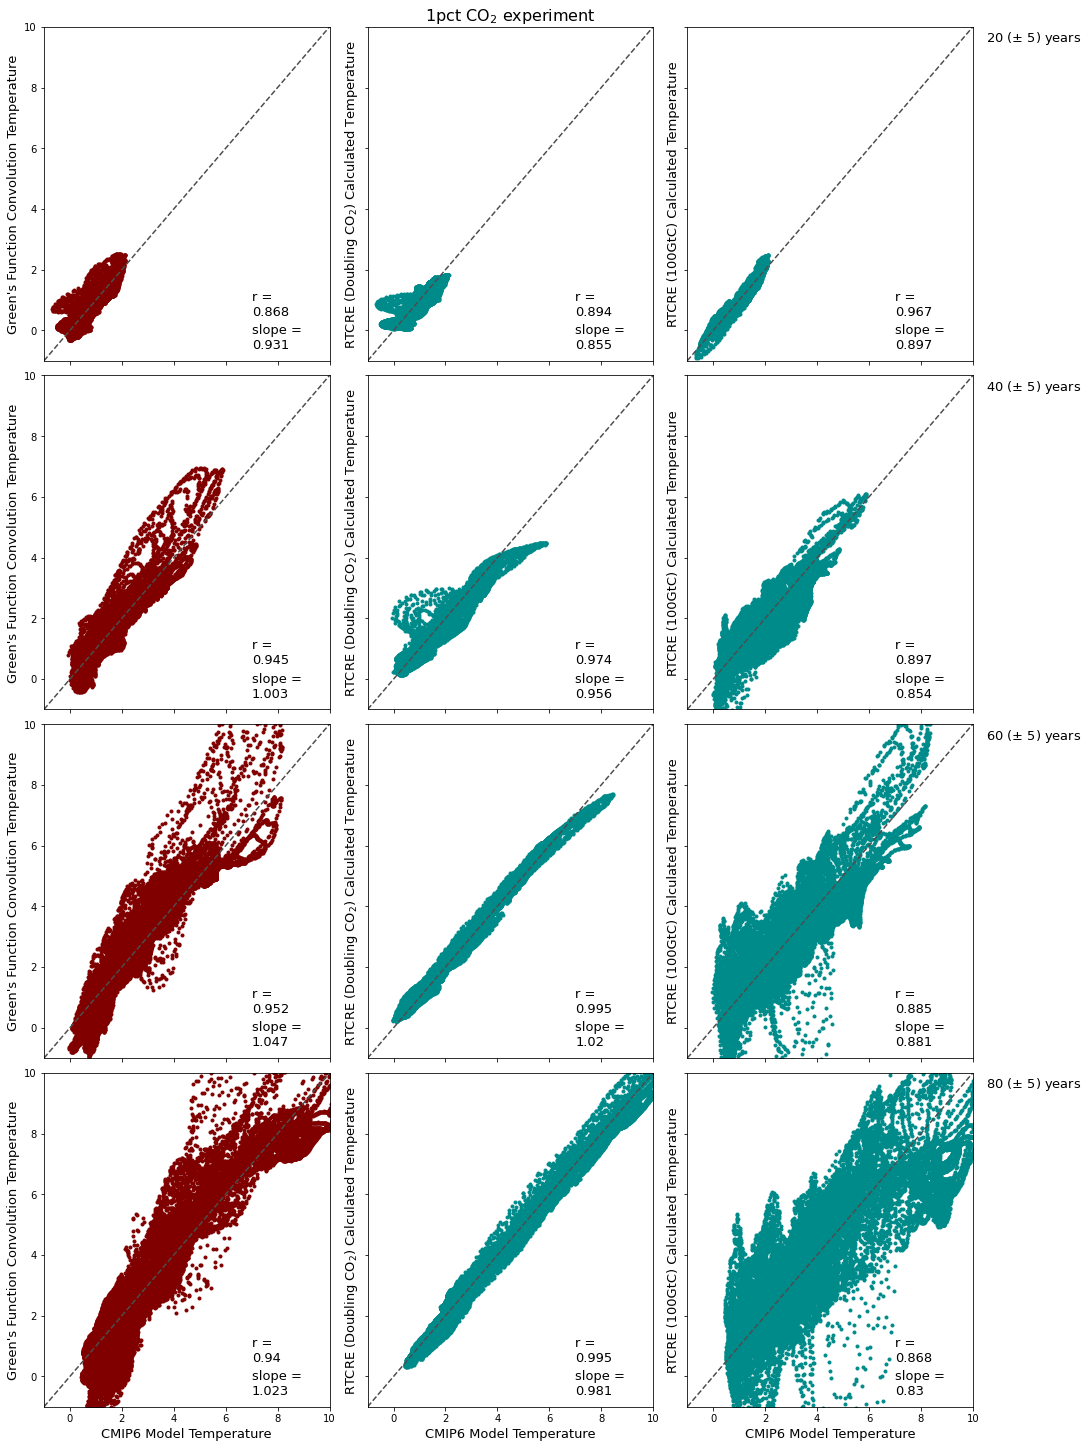

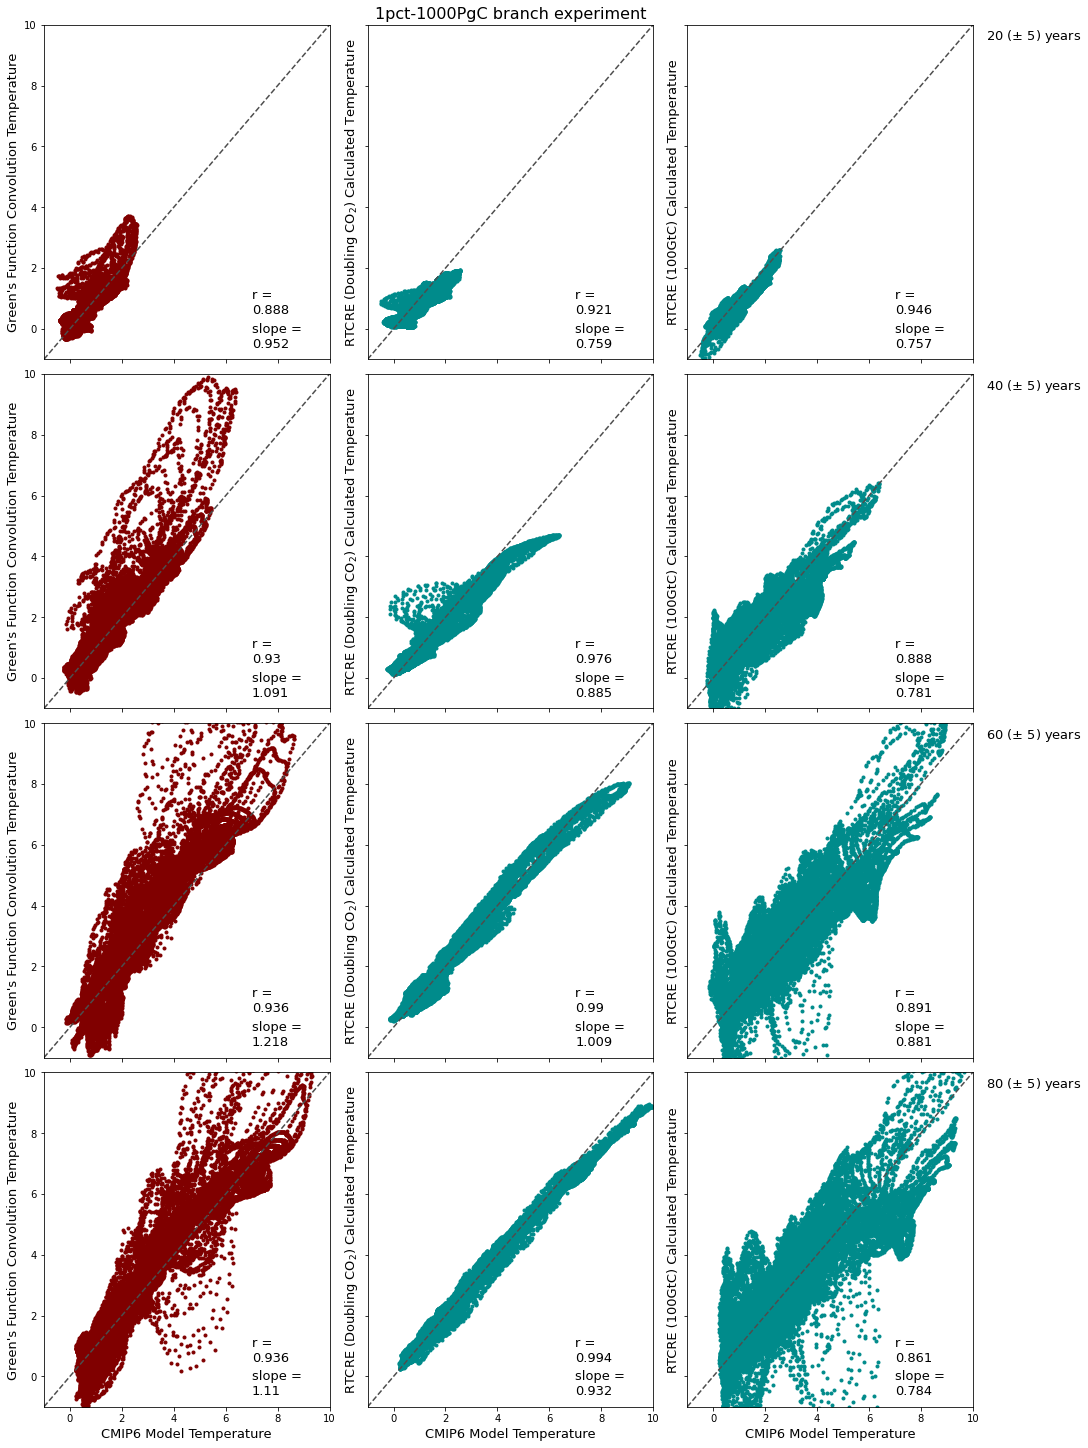

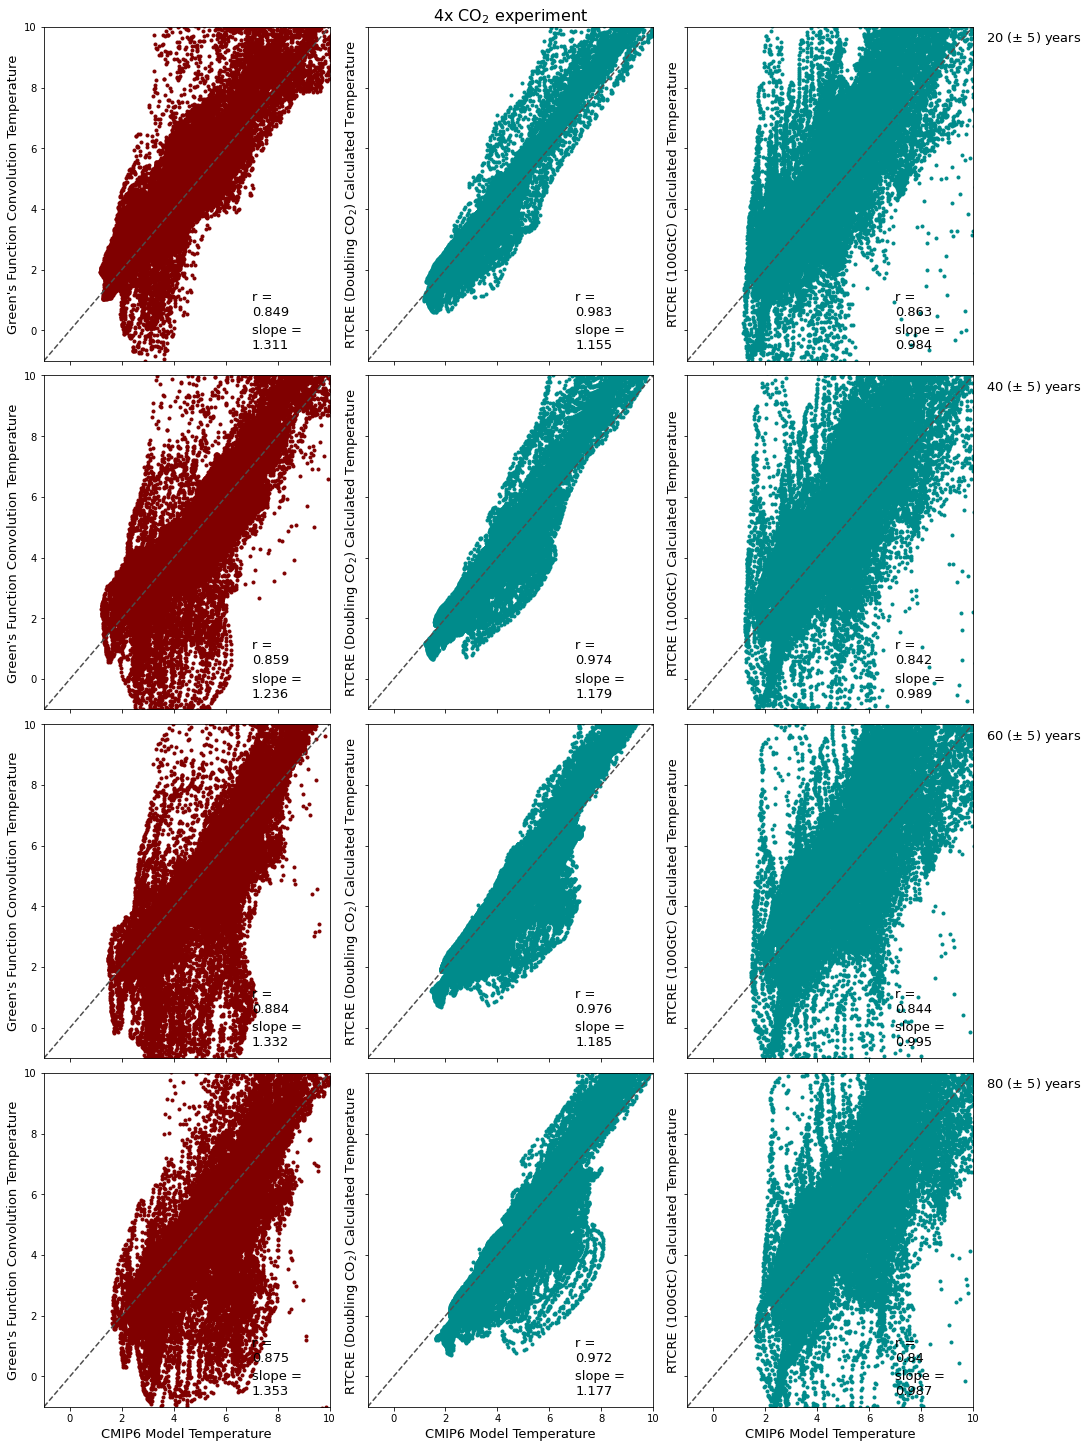

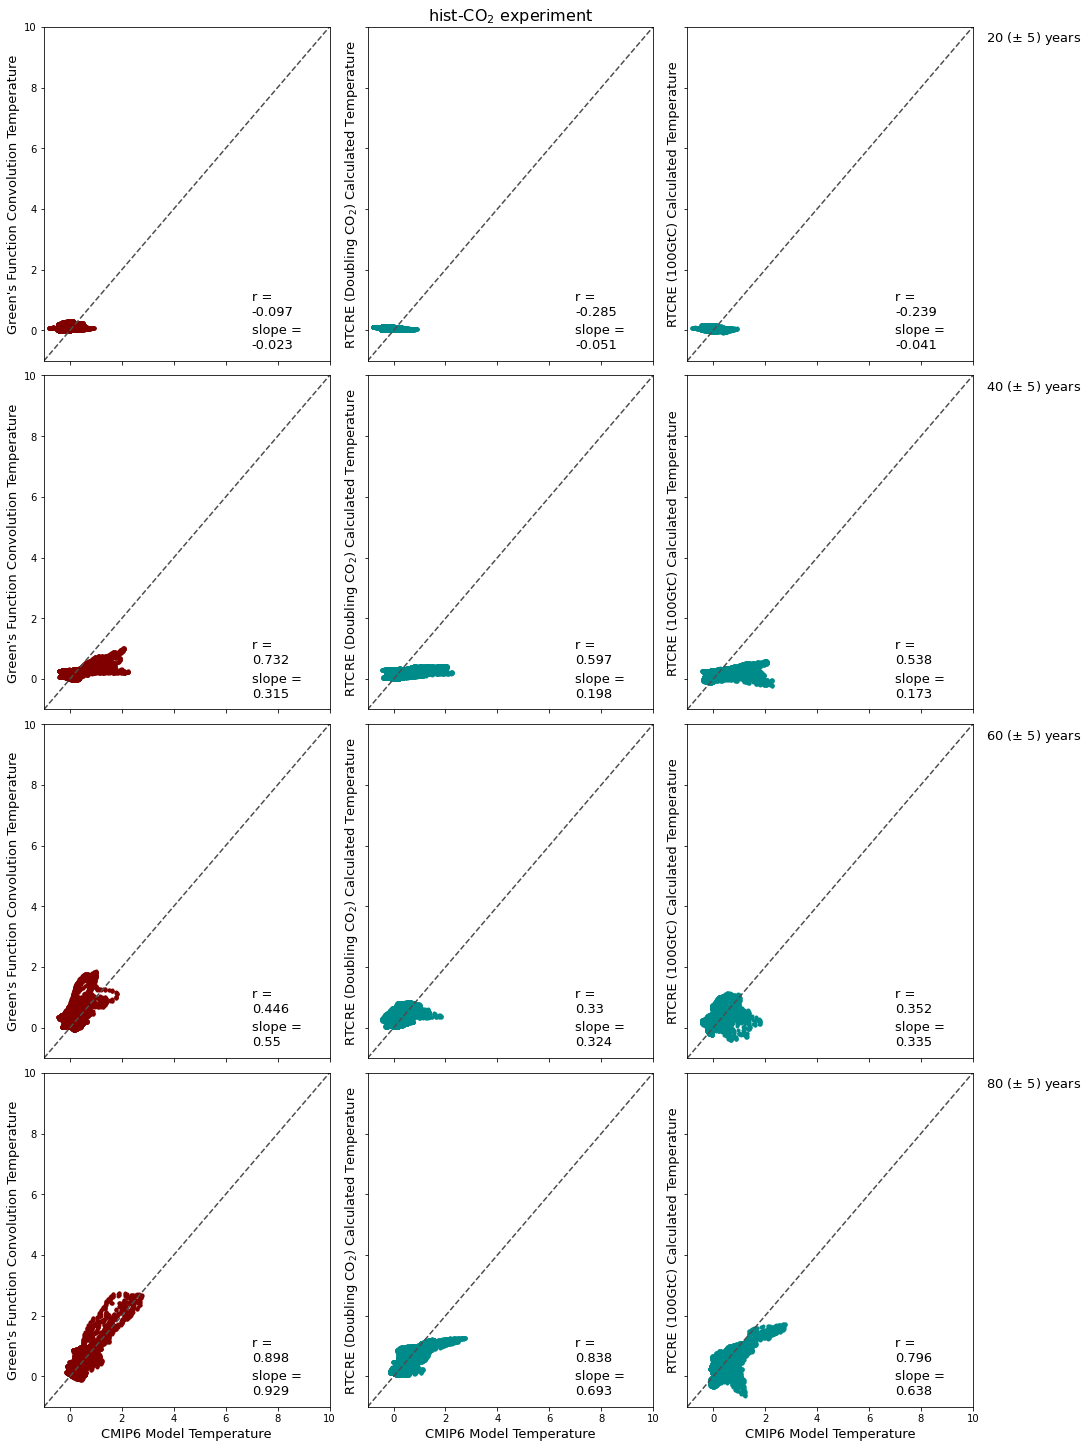

In [59]:
from scipy.stats import linregress

for exp in ['1pct','1000gtc','4x','hist']:
    fig, axes = plt.subplots(4,3, sharex = True, sharey = True, constrained_layout = True, figsize = [15,20])
    yr_dif = 5
    for idx_t, t in enumerate([20,40,60,80]):
        ax1 = axes[idx_t, 0]
        ax2 = axes[idx_t, 1]
        ax3 = axes[idx_t, 2]
        ax1.scatter(x = dif_ds.sel(experiment = exp).sel(s = slice(t-yr_dif,t+yr_dif)).mean(dim = 's')['tas'], 
                    y = conv_ds.sel(experiment = exp).sel(s = slice(t-yr_dif,t+yr_dif)).mean(dim = 's'), marker = '.', color = 'maroon')

        lr = linregress((dif_ds.sel(experiment = exp).sel(s = slice(t-yr_dif,t+yr_dif)).mean(dim = 's')['tas'].values).flatten(), 
              (conv_ds.sel(experiment = exp).sel(s = slice(t-yr_dif,t+yr_dif)).mean(dim = 's').values).flatten())

        ax1.text(7,0.5, f'r =\n{np.round(lr.rvalue, 3)}', fontsize = 13)
        ax1.text(7,-0.6, f'slope =\n{np.round(lr.slope, 3)}', fontsize = 13)

        RTCRE_yr = 70
        ax2.scatter(x = dif_ds.sel(experiment = exp).sel(s = slice(t-yr_dif,t+yr_dif)).mean(dim = 's')['tas'], 
                    y = RTCRE_conv.sel(year = RTCRE_yr).sel(experiment = exp).sel(s = slice(t-yr_dif,t+yr_dif)).mean(dim = 's'), marker = '.', color = 'darkcyan')

        lr = linregress((dif_ds.sel(experiment = exp).sel(s = slice(t-yr_dif,t+yr_dif)).mean(dim = 's')['tas'].values).flatten(),
                        (RTCRE_conv.sel(year = RTCRE_yr).sel(experiment = exp).sel(s = slice(t-yr_dif,t+yr_dif)).mean(dim = 's').values).flatten())

        ax2.text(7,0.5, f'r =\n{np.round(lr.rvalue, 3)}', fontsize = 13)
        ax2.text(7,-0.6, f'slope =\n{np.round(lr.slope, 3)}', fontsize = 13)


        RTCRE_yr = 20
        ax3.scatter(x = dif_ds.sel(experiment = exp).sel(s = slice(t-yr_dif,t+yr_dif)).mean(dim = 's')['tas'], 
                    y = RTCRE_conv.sel(year = RTCRE_yr).sel(experiment = exp).sel(s = slice(t-yr_dif,t+yr_dif)).mean(dim = 's'), marker = '.', color = 'darkcyan')

        lr = linregress((dif_ds.sel(experiment = exp).sel(s = slice(t-yr_dif,t+yr_dif)).mean(dim = 's')['tas'].values).flatten(),
                        (RTCRE_conv.sel(year = RTCRE_yr).sel(experiment = exp).sel(s = slice(t-yr_dif,t+yr_dif)).mean(dim = 's').values).flatten())

        ax3.text(7,0.5, f'r =\n{np.round(lr.rvalue, 3)}', fontsize = 13)
        ax3.text(7,-0.6, f'slope =\n{np.round(lr.slope, 3)}', fontsize = 13)


        ax1.set_xlim(-1.,10.)
        ax1.set_ylim(-1.,10.)
        ax1.set_ylabel('Green\'s Function Convolution Temperature', fontsize = 13)

        ax2.set_ylabel('RTCRE (Doubling CO$_2$) Calculated Temperature', fontsize = 13)
        ax3.set_ylabel('RTCRE (100GtC) Calculated Temperature', fontsize = 13)

        ax1.plot(ax1.get_xlim(), ax1.get_ylim(), ls="--", c=".3")
        ax2.plot(ax2.get_xlim(), ax2.get_ylim(), ls="--", c=".3")
        ax3.plot(ax3.get_xlim(), ax3.get_ylim(), ls="--", c=".3")

        ax3.text(x = 10.5, y = 9.5, s = f'{t} ($\pm$ 5) years', fontsize = 13)
    ax1.set_xlabel('CMIP6 Model Temperature', fontsize = 13)
    ax2.set_xlabel('CMIP6 Model Temperature', fontsize = 13)
    ax3.set_xlabel('CMIP6 Model Temperature', fontsize = 13)
    axes[0,1].set_title(exp_dict[exp], fontsize = 16)
    plt.savefig(f'figures/paper/supplement/RTCRE_GF_linregress_{exp}.png', bbox_inches = 'tight', dpi = 150)